<a href="https://colab.research.google.com/github/mafaldasalomao/DCGAN_MNIST_TENSORFLOW/blob/main/cGAN_Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
import time 
import datetime 
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
tf.random.set_seed(42)

In [3]:
dataset = 'maps'


Outros datasets além do `maps`: 
* `cityscapes`
* `edges2handbags`
* `edges2shoes`
* `facades`
* `night2day`

(https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models)

In [4]:
arquivo_dataset = "{}.tar.gz".format(dataset)
url_dataset = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(arquivo_dataset)
print(url_dataset)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [5]:
download_zip = tf.keras.utils.get_file(fname= arquivo_dataset, origin = url_dataset, extract = True)

250242400/250242400 [==============================] - 73s 0us/step


In [6]:
download_zip = pathlib.Path(download_zip)

In [7]:
caminho = download_zip.parent/dataset

In [8]:
caminho

PosixPath('/root/.keras/datasets/maps')

In [9]:
list(caminho.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps.tar.gz'),
 PosixPath('/root/.keras/datasets/maps')]

In [10]:
amostra = tf.io.read_file(str(caminho / 'train/1.jpg'))
amostra = tf.io.decode_jpeg(amostra)

In [11]:
print(amostra.shape)

(600, 1200, 3)


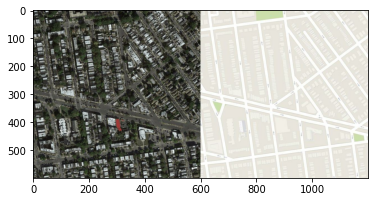

In [12]:
plt.figure()
plt.imshow(amostra);

In [13]:
def carregar_imagem(img_arquivo):
  img = tf.io.read_file(img_arquivo)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])


  largura = tf.shape(img)[1]
  largura = largura // 2
  img_original = img[:, :largura, :]
  img_transformada = img[:, largura:, :]

  img_original = tf.cast(img_original, tf.float32)
  img_transformada = tf.cast(img_transformada, tf.float32)
  return img_original, img_transformada

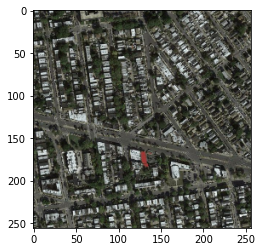

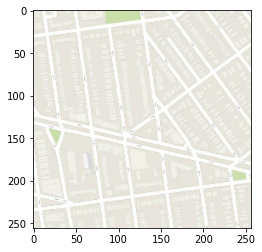

In [14]:
img_original, img_transformada = carregar_imagem(str(caminho / 'train/1.jpg'))
plt.figure()
plt.imshow(img_original/255.0);
plt.figure()
plt.imshow(img_transformada/255.0);

In [15]:
qtd_treinamento = tf.data.Dataset.list_files(str(caminho / 'train/*.jpg'))
qtd_treinamento

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [16]:
qtd_treinamento = len(list(qtd_treinamento))
qtd_treinamento

1096

In [17]:
buffer_size = qtd_treinamento
batch_size = 1
img_largura = 256
img_altura = 256


In [18]:
def redimensionar(img_original, img_transformada, altura, largura):
  img_original = tf.image.resize(img_original, [largura, altura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img_transformada = tf.image.resize(img_transformada, [largura, altura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img_original, img_transformada

In [19]:
def normalizar(img_original, img_transformada):
  img_original = (img_original / 127.5) - 1
  img_transformada = (img_transformada / 127.5) - 1
  return img_original, img_transformada

In [20]:
def crop_aleatorio(img_original, img_transformada):
  img_empilhada = tf.stack([img_original, img_transformada], axis = 0)
  img_crop = tf.image.random_crop(img_empilhada, size = [2, img_altura, img_largura, 3])
  return img_crop[0], img_crop[1]

In [21]:
@tf.function()
def jitter_aleatorio(img_original, img_transformada):
  img_original, img_transformada = redimensionar(img_original, img_transformada, 286, 286)
  img_original, img_transformada = crop_aleatorio(img_original, img_transformada)
  if tf.random.uniform(()) > 0.5:
    img_original = tf.image.flip_left_right(img_original)
    img_transformada = tf.image.flip_left_right(img_transformada)
  return img_original, img_transformada


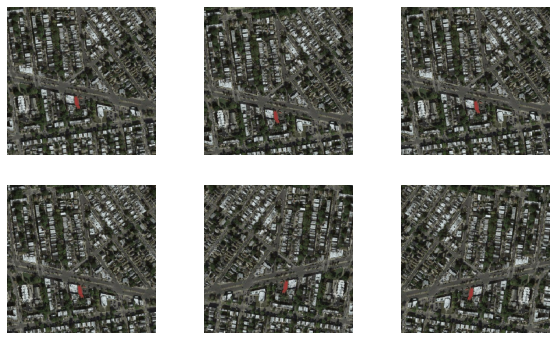

In [22]:
plt.figure(figsize=(10, 6))
for i in range(6):
  j_original, j_transformada = jitter_aleatorio(img_original, img_transformada)
  plt.subplot(2, 3, i+1)
  plt.imshow(j_original/255.0)
  plt.axis('off')
plt.show()

In [23]:
def carrega_img_treinamento(img_arquivo):
  img_original, img_transformada = carregar_imagem(img_arquivo)
  img_original, img_transformada = jitter_aleatorio(img_original, img_transformada)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [24]:
def carrega_img_teste(img_arquivo):
  img_original, img_transformada = carregar_imagem(img_arquivo)
  img_original, img_transformada = redimensionar(img_original, img_transformada, img_altura, img_largura)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [25]:
dataset_treinamento = tf.data.Dataset.list_files(str(caminho / 'train/*.jpg'))
dataset_treinamento = dataset_treinamento.map(carrega_img_teste, num_parallel_calls=tf.data.AUTOTUNE)
dataset_treinamento = dataset_treinamento.shuffle(buffer_size)
dataset_treinamento = dataset_treinamento.batch(batch_size)

In [26]:
dataset_treinamento

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>

In [27]:
try:
  dataset_teste = tf.data.Dataset.list_files(str(caminho / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  dataset_teste = tf.data.Dataset.list_files(str(caminho / 'val/*.jpg'))
dataset_teste = dataset_teste.map(carrega_img_teste)
dataset_teste = dataset_teste.batch(batch_size)

In [28]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02) #initial weigths
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    resultado.add(tf.keras.layers.BatchNormalization())
  resultado.add(tf.keras.layers.LeakyReLU())
  return resultado

In [29]:
down_model = encode(3, 4)
down_result = down_model(tf.expand_dims(img_original, 0))
down_result.shape, down_result

(TensorShape([1, 128, 128, 3]),
 <tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
 array([[[[-0.53463614, -5.646207  ,  6.422633  ],
          [-0.75390553, -8.852712  ,  5.6169677 ],
          [ 5.861742  , -4.153292  , -0.5117187 ],
          ...,
          [ 3.4704435 , -3.7092688 ,  2.1383903 ],
          [ 6.7089767 , -3.3617117 ,  0.7601871 ],
          [ 3.8211954 , -1.7040004 , -1.1345572 ]],
 
         [[13.285101  , -2.0002913 ,  1.9650729 ],
          [36.679066  , -1.9930032 , -2.8057086 ],
          [35.95874   , -0.96375066, -4.8817987 ],
          ...,
          [18.149252  , -2.3835287 , -2.1458414 ],
          [15.457751  , -2.4966056 , -2.0075567 ],
          [17.047253  ,  0.9337823 , -3.0326335 ]],
 
         [[ 3.57712   , -1.261907  , -0.3998685 ],
          [ 5.736351  , -4.1997952 , -0.2322948 ],
          [ 2.33692   , -3.2716    , -3.199999  ],
          ...,
          [18.298935  , -2.1449268 , -2.4808936 ],
          [14.863747  , -3.0127835 , -3.43

In [30]:
def decode(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0, 0.02) #initial weigths
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
  resultado.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    resultado.add(tf.keras.layers.Dropout(0.5))
  resultado.add(tf.keras.layers.ReLU())
  return resultado

In [31]:
up_model = decode(3, 4)
up_result = up_model(down_result)
up_result.shape, up_result

(TensorShape([1, 256, 256, 3]),
 <tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.        , 0.06563975, 0.04680609],
          [0.03137051, 0.        , 0.1259287 ],
          [0.        , 0.3915141 , 0.        ],
          ...,
          [0.03935897, 0.00275757, 0.10026316],
          [0.00556398, 0.19917484, 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.38580826],
          [0.        , 1.0518901 , 1.8007877 ],
          [0.        , 0.        , 0.54634243],
          ...,
          [0.        , 0.16527596, 0.95507175],
          [0.        , 0.        , 0.        ],
          [0.01418648, 0.        , 0.13868815]],
 
         [[0.        , 0.0954804 , 0.1582742 ],
          [0.23730999, 1.0795352 , 0.28517273],
          [0.        , 0.70480984, 0.3543909 ],
          ...,
          [0.20993973, 0.37806526, 0.38086945],
          [0.        , 0.5633703 , 0.25051808],
          [0.        , 0.05626234, 0.01844

In [32]:
def Gerador():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
      encode(128, 4),  # (batch_size, 64, 64, 128)
      encode(256, 4),  # (batch_size, 32, 32, 256)
      encode(512, 4),  # (batch_size, 16, 16, 512)
      encode(512, 4),  # (batch_size, 8, 8, 512)
      encode(512, 4),  # (batch_size, 4, 4, 512)
      encode(512, 4),  # (batch_size, 2, 2, 512)
      encode(512, 4),  # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
      decode(512, 4),  # (batch_size, 16, 16, 512)
      decode(256, 4),  # (batch_size, 32, 32, 256)
      decode(128, 4),  # (batch_size, 64, 64, 128)
      decode(64, 4),  # (batch_size, 128, 128, 64)
  ]

  canais_saida = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(canais_saida, 4, strides=2, padding='same', 
                                         kernel_initializer=initializer, activation = 'tanh')  # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs = inputs, outputs = x)

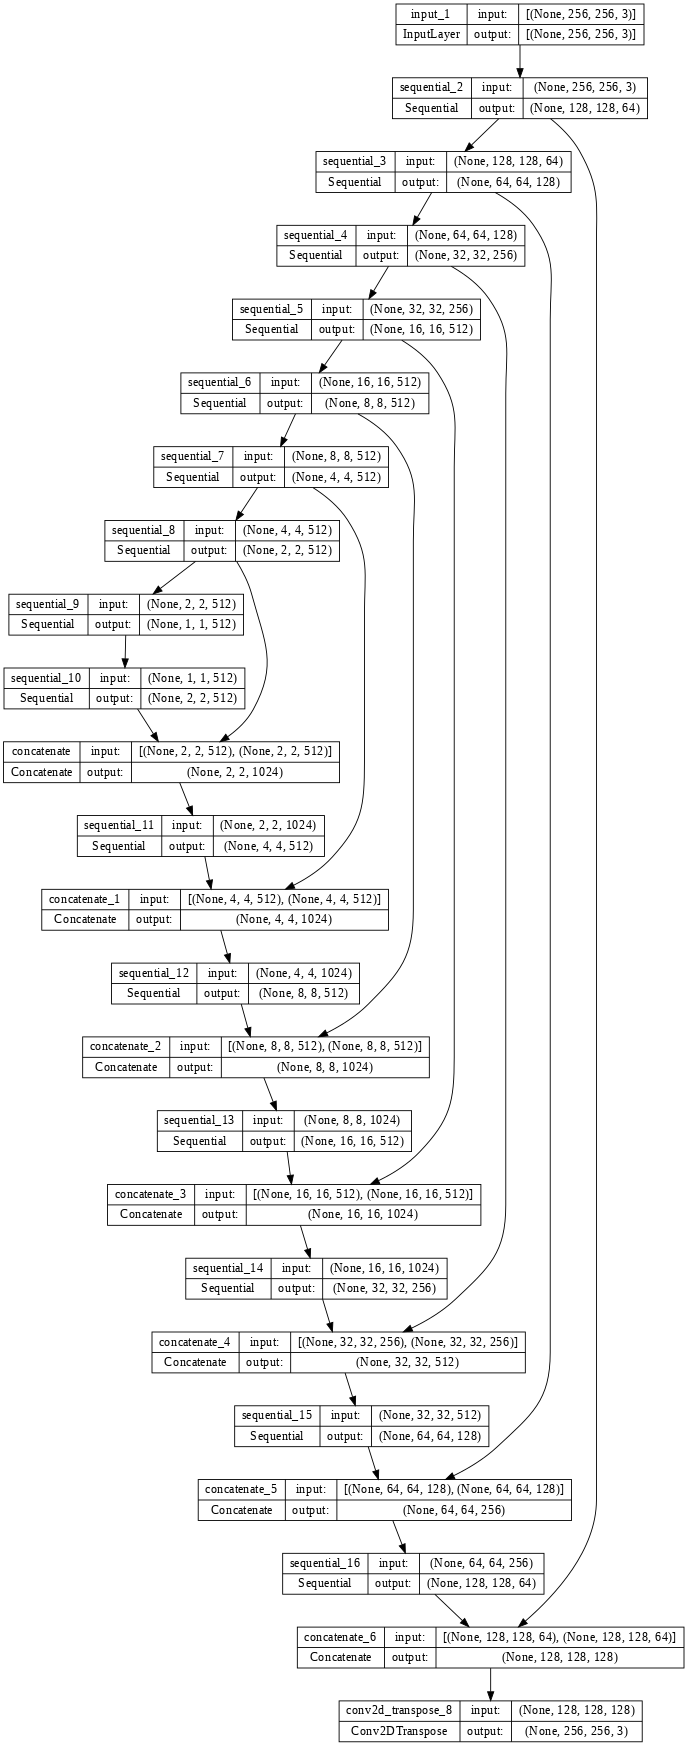

In [33]:
gerador = Gerador()
tf.keras.utils.plot_model(gerador, show_shapes = True, dpi = 64)

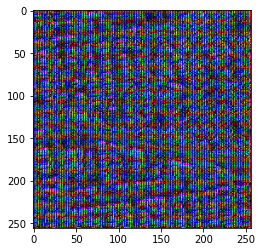

In [34]:
g_saida= gerador(img_original[tf.newaxis,...], training=False)
plt.imshow(g_saida[0, ...]);

In [35]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [36]:
loss= tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [68]:
def loss_gerador(d_saida_gerada, g_saida, target):
  gan_loss = loss(tf.ones_like(d_saida_gerada), d_saida_gerada)
  l1_loss = tf.reduce_mean(tf.abs(target - g_saida))
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

In [38]:
def Discriminador():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape=[256, 256, 3], name = 'img_original')
  transformada = tf.keras.layers.Input(shape=[256, 256, 3], name='img_transformada')

  x = tf.keras.layers.concatenate([original, transformada]) # (batchsize, 256, 256, canais*2)

  down1 = encode(64, 4, False)(x)
  down2 = encode(128, 4)(down1)
  down3 = encode(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias = False)(zero_pad1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer= initializer)(zero_pad2)

  return tf.keras.Model(inputs=[original, transformada], outputs = last)

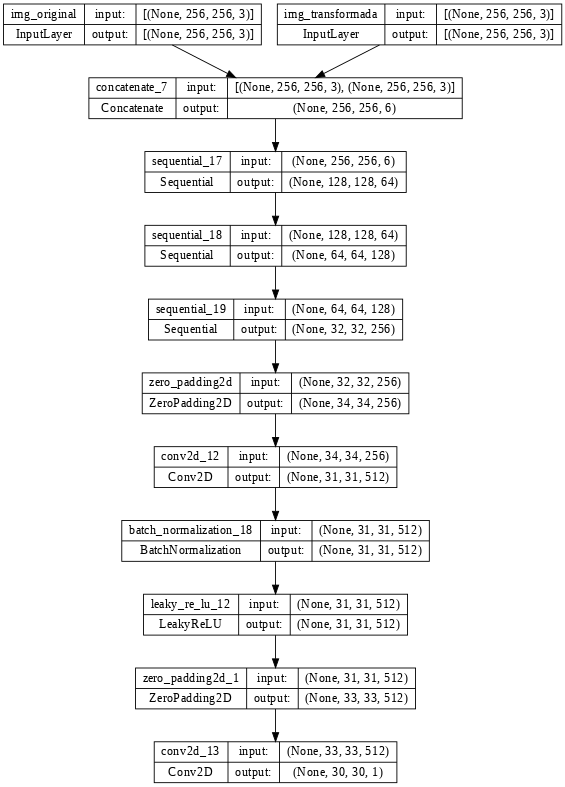

In [39]:
discriminador = Discriminador()
tf.keras.utils.plot_model(discriminador, show_shapes=True, dpi=64)

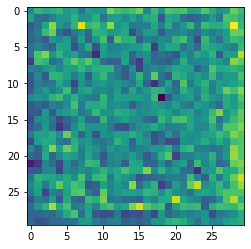

In [40]:
d_saida = discriminador([img_original[tf.newaxis, ...], g_saida], training=False)
plt.imshow(d_saida[0,..., -1])

In [41]:
def loss_discriminador(d_saida_real, d_saida_gerada):
  loss_real = loss(tf.ones_like(d_saida_real), d_saida_real)
  loss_gerada = loss(tf.zeros_like(d_saida_gerada), d_saida_gerada)
  d_loss_total = loss_real + loss_gerada
  return d_loss_total

In [42]:
optimizer_gerador = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_discriminador = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = optimizer_gerador,
                                 discriminator_optimizer= optimizer_discriminador,
                                 generator = gerador,
                                 discriminator = discriminador)

In [47]:
def gerar_imagens( modelo, teste_entrada, real, etapa = None):
  gerada = modelo(teste_entrada, training=True)
  plt.figure(figsize=(13, 8))

  lista_imgs = [teste_entrada[0], real[0], gerada[0]]
  titulo = ["imagem entrada", "Real ('GTRUTH')", "Imagem Gerada"]
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(titulo[i])
    plt.imshow(lista_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  if etapa is  not None:
    plt.savefig('resultado_pix2pix_etapa_{}.png'. format(etapa), bbox_inches='tight')
  plt.show()

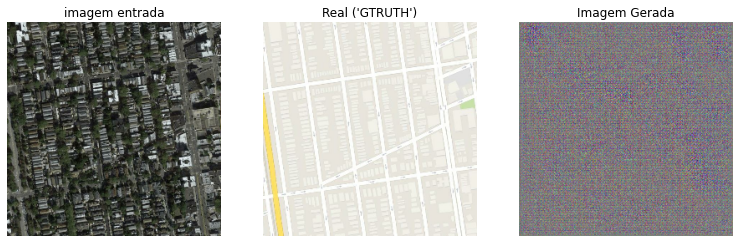

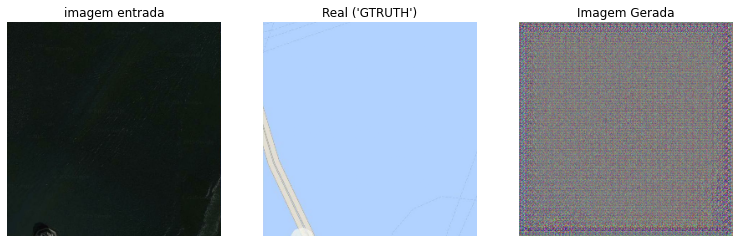

In [48]:
for entrada_exemplo, real_exemplo in dataset_teste.take(2):
  gerar_imagens(gerador, entrada_exemplo, real_exemplo)

In [53]:
caminho_log = 'logs/'
metricas = tf.summary.create_file_writer(caminho_log + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [70]:
@tf.function
def etapa_treinamento(img_entrada, real, etapa):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_saida = gerador(img_entrada, training = True)

    d_saida_real = discriminador([img_entrada, real], training = True)
    d_saida_gerada = discriminador([img_entrada, g_saida], training = True)

    g_loss_total, g_loss_gan, g_loss_l1 = loss_gerador(d_saida_gerada, g_saida, real)
    d_loss = loss_discriminador(d_saida_real, d_saida_gerada)

  gradients_gerador = g_tape.gradient(g_loss_total, gerador.trainable_variables)
  gradients_discriminador = d_tape.gradient(d_loss, discriminador.trainable_variables)

  optimizer_gerador.apply_gradients(zip(gradients_gerador, gerador.trainable_variables))
  optimizer_discriminador.apply_gradients(zip(gradients_discriminador, discriminador.trainable_variables))

  with metricas.as_default():
    tf.summary.scalar('g_loss_total', g_loss_total, step=etapa//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=etapa//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=etapa//1000)
    tf.summary.scalar('d_loss', d_loss, step=etapa//1000)

In [62]:
def treinar(base_treinamento, base_teste, etapas):
  entrada_exemplo, exemplo_real = next(iter(base_teste.take(1)))
  inicio = time.time()

  for etapa, (img_entrada, real) in base_treinamento.repeat().take(etapas).enumerate():
    if etapa % 1000 == 0:
      display.clear_output(wait = True)
      if etapa != 0:
        print(f'Tempo para executar 1000 etapas: {time.time() - inicio:.2f} segundos\n')
      inicio = time.time()
      gerar_imagens(gerador, entrada_exemplo, exemplo_real, etapa)
      print(f"Etapa: {etapa//1000}K")
    etapa_treinamento(img_entrada, real, etapa)
    if (etapa + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (etapa + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefixo)
      gerador.save_weights('modelo_pix2pix.h5')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {caminho_log}

Tempo para executar 1000 etapas: 104.51 segundos



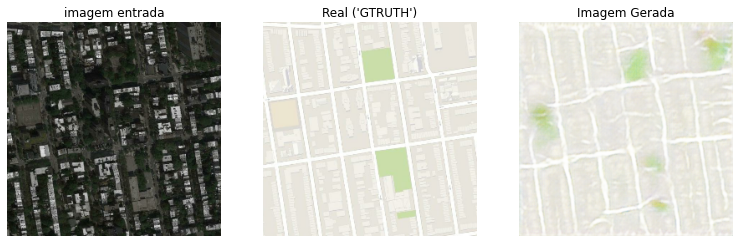

Etapa: 4K
..

In [ ]:
treinar(dataset_treinamento, dataset_teste, etapas= 20000)

### Observações sobre o treinamento

Algumas coisas para levar em consideração: 

* Note que nem o gerador nem o discriminador "ganham" um do outro. Se ou o `g_loss_gan` ou o `d_loss` estão muito baixos, é um indicador de que este modelo está dominando o outro, o que significa que não está treinando os dois em conjunto como deveria. 

* O valor `log(2) = 0.69` é um bom ponto de referência para essas perdas, pois indica que o discriminador no geral está incerto sobre a sua avaliação (real ou falso)
* Para `d_loss`, um valor abaixo de 0.69 significa que o discriminador está se saindo melhor do que uma classificação aleatória no conjunto combinado de imagens reais e geradas. 
* Para `g_loss_gan`, um valor abaixo de 0.69 significa que o gerador treinado está enganando o discriminador melhor do que se fosse geração aleatória apenas   
* Ao longo do treinamento, `g_loss_l1` deve diminuir. 

## Restaurando checkpoint

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
modelo_pretreinado = Gerador()
modelo_pretreinado.load_weigths('content/modelo_pix2pix.h5')

In [ ]:
for satelite, mapa in dataset.take(5):
  gerar_imagens(modelo_pretreinado, satelite, mapa)

Códigos de referência:
* https://github.com/affinelayer/pix2pix-tensorflow/blob/master/pix2pix.py
* https://www.tensorflow.org/tutorials/generative/pix2pix
